# Tutorial

ldcpy is a utility for gathering and plotting metrics from NetCDF or Zarr files using the Pangeo stack. This tutorial notebook targets comparing CESM data in its original form to CESM data that has undergone lossy compression (meaning that the reconstructed file is not exactly equivalent to the original file).  The tools provided in ldcpy are intended to highlight differences due to compression artifacts in order to assist scientist in evaluating the amount of lossy compression to apply to their data.

The CESM data used here are NetCDF files in "timeseries" file format, meaning that each NetCDF file contains one (major) output variable (e.g., surface temperature or precipitation rate) and spans multiple timesteps (daily, monthly, 6-hourly, etc.).  CESM timeseries files are regularly released in large public datasets.


In [1]:
# Add ldcpy root to system path
import sys
sys.path.insert(0,'../../../')

# Import ldcpy package
# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
%load_ext autoreload
%autoreload 2
import ldcpy

#display the plots in this notebook
%matplotlib inline

## Overview

This notebook demonstrates the use of ldcpy on the sample data included with this package.  It explains how to open datasets (and view metadata), display basic statistics about the data, and create both time-series and spatial plots of the datasets and related metrics.  Plot examples start out with the essential arguments, and subsequent examples explore the additional plotting options that are available. 

For information about installation, see [these instructions](https://ldcpy.readthedocs.io/en/latest/installation.html), and for information about usage, see the API reference [here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot).

## Loading Datasets and Viewing Metadata

The first step in comparing the data is to load the data from the files that we are interested into a "collection" for ldcpy to use. To do this, we use ldcpy.open_datasets(). This function requires the following three arguments:
    
 - _varnames_ : the variable(s) of interest to combine across files (typically the timeseries file variable name)
 - _list_of_files_ : a list of full file paths (either relative or absolute)
 - _labels_ : a corresponding list of names (or labels) for each file in the collection 
    
Note: This function is a wrapper for xarray.open_mfdatasets(), and any additional key/value pairs passed in as a dictionary are used as arguments to xarray.open_mfdatasets().  For example, specifying the chunk size ("chunks") will be important for large data (see LargeDataGladeNotebook.ipynb for more information and an example).

We setup three different collections of timeseries datasets in these examples:
 -  _col_ds_ contains daily surface temperature (TS) data (2D data) for 100 days
 - _col_ds2_ contains daily precipitation rate (PRECT) data (2D data) for 60 days
 -  _col_ds3_ contains monthly temperature (T) data (3D data) for 3 months

These datasets are collections of variable data from several different netCDF files, which are given labels in the third parameter to the ldcpy.open_datasets() function. These names/labels can be whatever you want (e.g., "orig", "control", "bob", ...), but they should be informative because the names will be used to select the appropriate dataset later and as part of the plot titles.

In this example, in each dataset collection we include a file with the original (uncompressed) data as well as additional file(s) with the same data subject to different levels of lossy compression. 

_Note: If you do not need to get the data from files (e.g., you have already used xarray.open_dataset()), then use ldcpy.collect_datasets() instead  of ldcpy.open_datasets (see example in AWSDataNotebook.ipynb)._

In [2]:
# col_ds contains TS data
col_ds = ldcpy.open_datasets(["TS"],['../../../data/cam-fv/orig.TS.100days.nc', 
                                 '../../../data/cam-fv/zfp1.0.TS.100days.nc', 
                                 '../../../data/cam-fv/zfp1e-1.TS.100days.nc'],
                         ['orig', 'zfpA1.0', 'zfpA1e-1'])
# col_ds2 contains PRECT data
col_ds2 = ldcpy.open_datasets(["PRECT"],['../../../data/cam-fv/orig.PRECT.60days.nc', 
                                     '../../../data/cam-fv/zfp1e-7.PRECT.60days.nc', 
                                     '../../../data/cam-fv/zfp1e-11.PRECT.60days.nc'],
                         ['orig', 'zfpA1e-7', 'zfpA1e-11'])
# col_ds3 contains 3D T data (here we specify the chunk to be a single timeslice)
col_ds3 = ldcpy.open_datasets(["T"],['../../../data/cam-fv/cam-fv.T.3months.nc',
                                 '../../../data/cam-fv/c.fpzip.cam-fv.T.3months.nc'],
                          ['orig', 'comp'], chunks={'time': 1})

dataset size in GB 0.07

dataset size in GB 0.04

dataset size in GB 0.04



***
Note that running the open_datasets function (as above) prints out the size of each dataset collection. For _col_ds3_,
the chunks parameter is used by DASK (which is further explained in LargeDataGladeNotebook.ipynb).

Printing a dataset collection reveals the dimension names, sizes, datatypes and values, among other metadata. The dimensions and the length of each dimension are listed at the top of the output. Coordinates list the dimensions vertically, along with the data type of each dimension and the coordinate values of the dimension (for example, we can see that the 192 latitude data points are spaced evenly between -90 and 90). Data variables lists all the variables available in the dataset. For these timeseries files, only the one (major) variable will be of interest.  For _col_ds3_ , that variable is temperature (T), which was specified in the first argument of the open_datasets() call. The so-called major variable will have the required "lat", "lon", and "time" dimensions.  If the variable is 3D (as in this example), a "lev" dimension will indicates that the dataset contains values at multiple altitudes (here, lev=30).  Finally, a "collection" dimension indicates that we concatenated several datasets together. (In this _col_ds3_ example, we concatonated 2 files together.)

In [3]:
#print information about col_ds3
col_ds3

<xarray.Dataset>
Dimensions:     (collection: 2, lat: 192, lev: 30, lon: 288, time: 3)
Coordinates:
  * time        (time) object 1920-02-01 00:00:00 ... 1920-04-01 00:00:00
  * lev         (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * collection  (collection) <U4 'orig' 'comp'
Data variables:
    T           (collection, time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 30, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.B20TRC5CNBDRD.f09_g16.031
    title:            UNSET
    logname:          mickelso
    host:             ys0219
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01-00000.nc
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...
    history:          Thu Jul  9 14:15:11 2020: ncks -d time,0,2,1 cam-fv.T.6...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...

### Printing Statistics 

The print_stats function can be used to compute and compare the overall statistics for a **single** timeslice in two datasets. To use this function, four arguments are required. In order, they are: 
 -   _ds_      - the collection of datasets read in from ldcpy.open_datasets() or ldcpy.collect_datasets()
 - _varname_ - the variable name we want to get statistics for (in this case 'TS' is the variable in our dataset collection _col_ds_ )
 -  _set1_    - the label of one particular dataset in the collection we are interested in ('orig')  
 -  _set2_    - and the label of another dataset that we want to compare it with ('zfpA1.0'). 
   
Additionally, one optional argument can be specified:

 -    _time_    - the time slice of data we want to get metrics for (default 0, which is the first slice)

In [4]:
# print 'TS' statistics about 'orig', 'zfpA1.0', and diff between the two datasets
ldcpy.print_stats(col_ds, 'TS', 'orig', 'zfpA1.0', time=0)

Comparing orig data (set1) to zfpA1.0 data (set2)
 
mean set1: 274.7
mean set2: 274.7
mean diff: 0.005767
 
variance set1: 534
variance set2: 533.7
 
standard deviation set1: 23.11
standard deviation set2: 23.1
 
max value set1: 315.6
max value set2: 315.6
min value set1: 216.7
min value set2: 216.8
 
max abs diff: 0.4059
min abs diff: 0
mean abs diff: 0.05852
mean squared diff: 3.326e-05
root mean squared diff: 0.07527
normalized root mean squared diff: 0.0007615
normalized max pointwise error: 0.004106
pearson correlation coefficient: 1
ks p-value: 0.00132
spatial relative error(% > 0.0001): 37.87
ssim: 0.9976


***
We can also generate metrics on a particular dataset. While this is done "behind the scenes" with the plotting functions, we first demonstrate here how the user can access this data without creating a plot.

We use an object of type ldcpy.DatasetMetrics to gather metrics on a dataset. To create an ldcpy.DatasetMetircs object, we first grab the particular dataset from our collection that we are interested in (in the usual xarray manner). For example, the following will grab the data for the TS variable labeled 'orig' in the _col_ds_ dataset that we created: 

In [5]:
# get the orig dataset
my_data = col_ds['TS'].sel(collection='orig')

Then we create a DatasetMetrics object using the data and a list of dimensions that we want to aggregate the data along.  We usually want to aggregate all of the timeslices ("time") or spatial points ("lat" and "lon"):

In [6]:
ds_metrics_across_time = ldcpy.DatasetMetrics(my_data, ["time"])
ds_metrics_across_space = ldcpy.DatasetMetrics(my_data, ["lat", "lon"])

Now when we call the get_metric() method on this class, a metric will be computed across each of these specified dimensions (in this case, "time"). 

In [7]:
my_data_mean_across_time = ds_metrics_across_time.get_metric("mean")
my_data_mean_across_space = ds_metrics_across_space.get_metric("mean")

my_data_mean_across_time.values

array([[228.94805908, 229.39446915, 229.42184357, ..., 229.37858994,
        228.95278442, 229.4450769 ],
       [229.3337999 , 229.38760071, 229.32789291, ..., 228.73066544,
        229.06293549, 229.02659225],
       [229.74119156, 229.81762497, 229.76844055, ..., 229.55835098,
        229.75506577, 229.57969193],
       ...,
       [237.00477859, 237.03717865, 237.06771225, ..., 236.91639221,
        236.94580048, 236.97352493],
       [236.69006699, 236.70527969, 236.7207486 , ..., 236.63906601,
        236.65667786, 236.6738382 ],
       [236.29601639, 236.29747787, 236.29879272, ..., 236.29072723,
        236.29267105, 236.29443573]])


There are many currently available metrics to choose from. A complete list of metrics that can be passed to get_metric() is available [here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot).



## Spatial Plots

### A Basic Spatial Plot

First we demonstrate the most  basic usage of the ldcpy.plot() function.  In its simplist form, ldcpy.plot() plots a single spatial plot of a dataset (i.e., no comparison) and requires:

 - _ds_      - the collection of datasets read in from ldcpy.open_datasets() (or ldcpy.collect_datasets())
 - _varname_ - the variable name we want to get statistics for
 - _set1_      - the label of one particular dataset in the collection that we are interested in
 - _metric_  - the name of the metric of interest
   
There are a number of optional arguments as well, that will be demonstrated in subsequent plots. These options include:

 - _set2_
 - _group_by_
 - _scale_
 - _metric_type_
 - _plot_type_
 - _transform_
 - _subset_
 - _lat_
 - _lon_
 - _lev_
 - _color_
 - _standardized_error_
 - _quantile_
 - _start_
 - _end_
    
A full explanation of each optional argument is available in the documentation [here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot). By default, a spatial plot of this data is created. The title of the plot contains the name of the dataset, the variable of interest, and the metric that is plotted. 

The following command generates a plot showing the mean TS (surface temperature) value from our dataset collection _col_ds_ over time at each point in the dataset labeled 'orig':

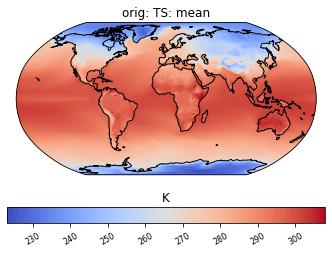

In [8]:
# plot of the mean TS values in the col_ds "orig" dataset
ldcpy.plot(col_ds, "TS", set1='orig', metric='mean')

We can also plot metrics other than the mean, such as the standard deviation at each grid point over time. We can also change the color scheme (for a full list of metrics and color schemes, see the [documentation](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot)). Here is an example of a plot of the same dataset from _col_ds_ as above but using a different color scheme and the standard deviation metric:

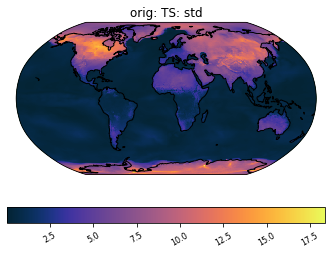

In [9]:
# plot of the standard deviation of TS values in the col_ds "orig" dataset
ldcpy.plot(col_ds, "TS", set1='orig', metric='std', color="cmo.thermal")

### Spatial Subsetting <a name="spatial_subsetting"></a>

Plotting the metric of a subset of the data (e.g., not all of the time slices in the dataset) is possible using the subset keyword.  In the plot below, we just look at "winter" data (Dec., Jan., Feb.). Other options for subset are available [here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot).

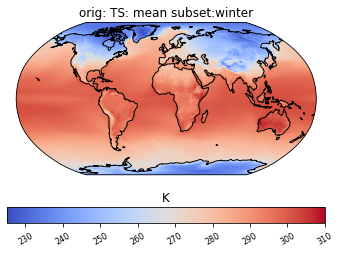

In [10]:
# plot of mean winter TS values in the col_ds "orig" dataset
ldcpy.plot(col_ds, "TS", set1='orig', metric='mean', subset="winter")

It is also possible to plot metrics for a subset of the time slices by specifying the start and end indices of the time we are interested in. This command creates a spatial plot of the mean TS values in "orig" for the first five days of data:

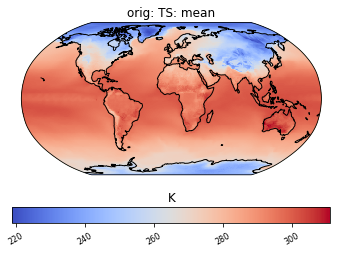

In [11]:
# plot of the first 5 TS values in the ds orig dataset
ldcpy.plot(col_ds, "TS", set1='orig', metric='mean', start=0, end=5)

Finally, for a 3D dataset, we can specify which vertical level to view using the "lev" keyword. Note that "lev" is a dimension in our dataset _col_ds3_ (see printed output for _col_ds3_ above), and in this case lev=30, meaning that lev ranges from 0 and 29, where 0 is at the surface (by default, lev=0):

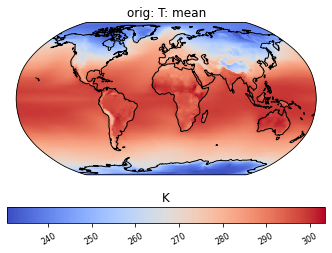

In [12]:
# plot of T values at lev=29 in the col_ds3 "orig" dataset
ldcpy.plot(col_ds3, "T", set1='orig', metric='mean', lev=29)

### Spatial Comparisons and Diff Plots

If we want a side-by-side comparison of two datasets, we need to specify an additional dataset name using the set2 argument, and a plot_type of "spatial_comparison". The plot below shows the mean TS value over time at each point in both the set1 (original) and set2 (compressed with zfp, tolerance 1.0) datasets in collection _col_ds_ .  Note that the "calc_ssim" argument indicates whether to calculate the SSIM (structural similarity index) comparing the plots (SSIM is between 0.0 and 1.0, where 1.0 means the plots are identical).

 SSIM =  0.99864



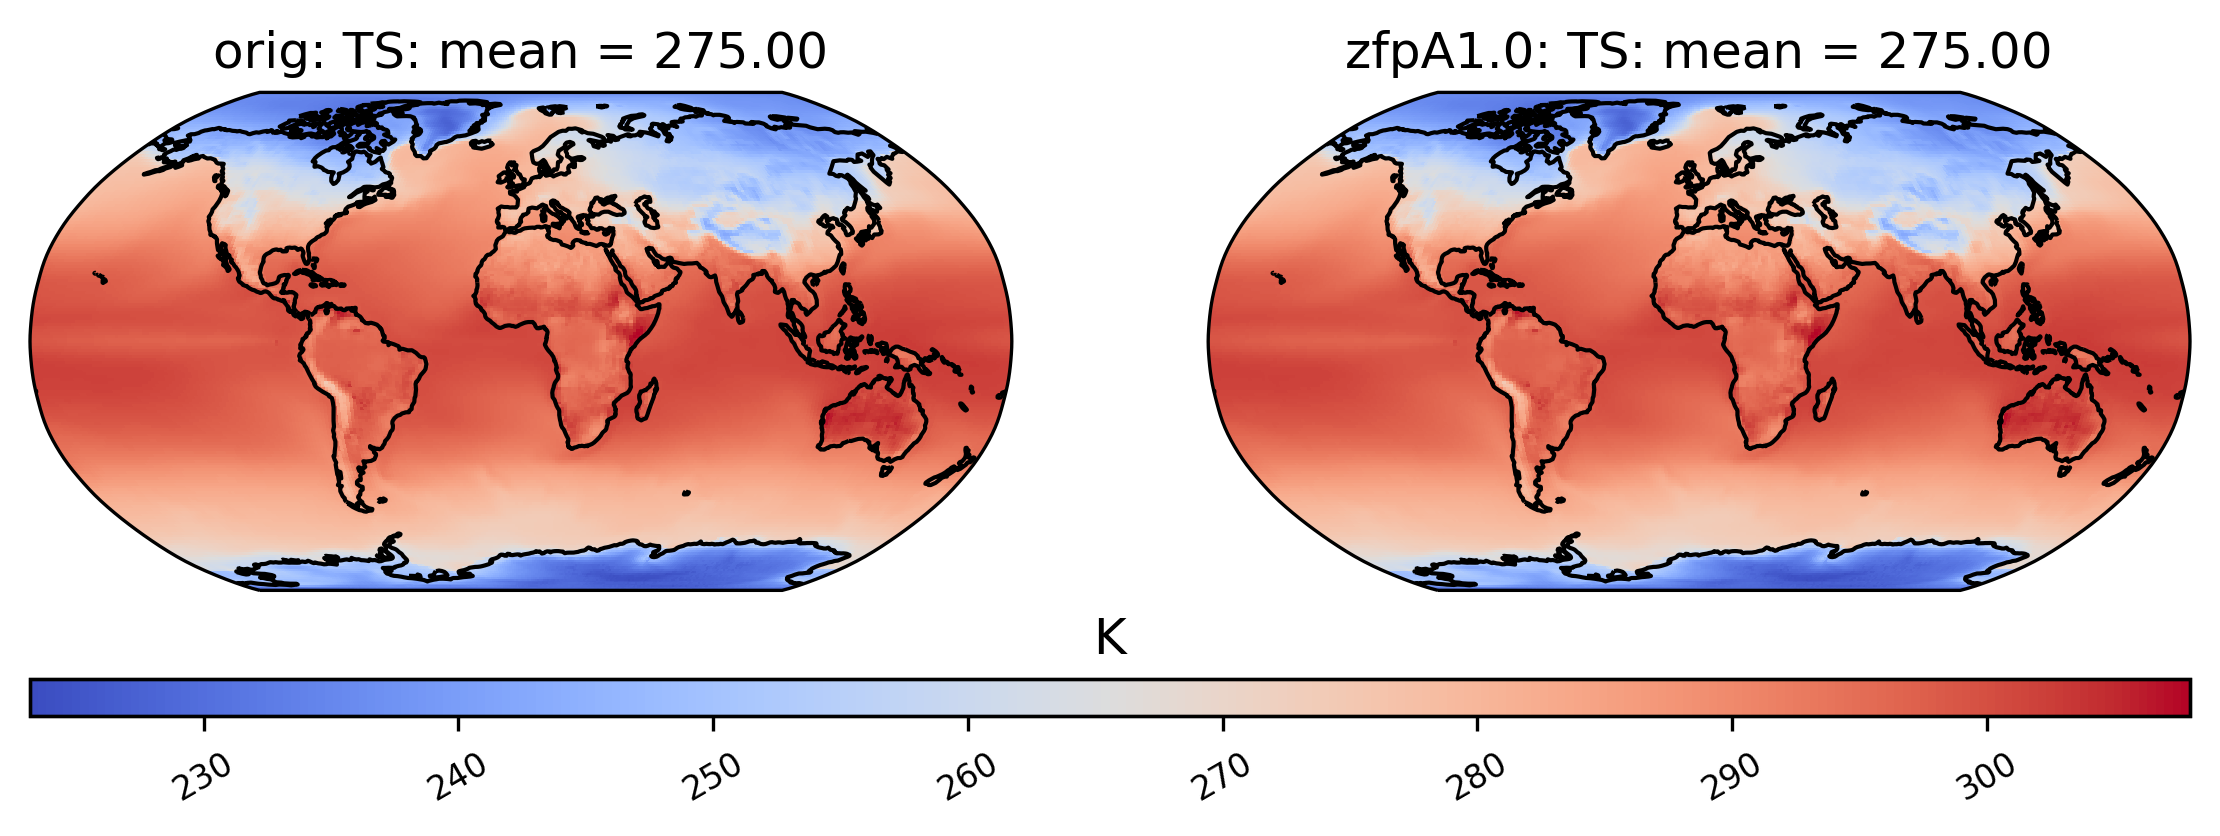

In [13]:
# comparison between mean TS values in col_ds for "orig" and "zfpA1.0" datasets
ldcpy.plot(col_ds, "TS", set1='orig', metric='mean', set2='zfpA1.0', 
           plot_type="spatial_comparison", calc_ssim = True)

To the eye, these plots look identical. This is because the effects of compression are small compared to the magnitude of the data. We can view the compression artifacts more clearly by plotting the difference between the two plots. This can be done by changing the plot_type back to 'spatial' (because we only want a single plot) and setting the metric_type to 'diff':

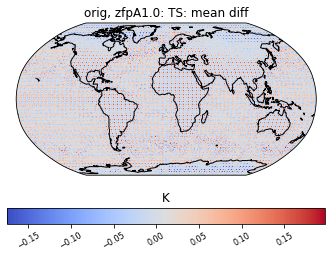

In [14]:
# diff between mean TS values in col_ds "orig" and "zfpA1.0" datasets
ldcpy.plot(col_ds, "TS", set1='orig', metric='mean', set2='zfpA1.0', 
           metric_type='diff', plot_type="spatial")

It is possible to compare two different compressed datasets side by side as well, by using a different dataset name for set1:

 SSIM =  0.99871



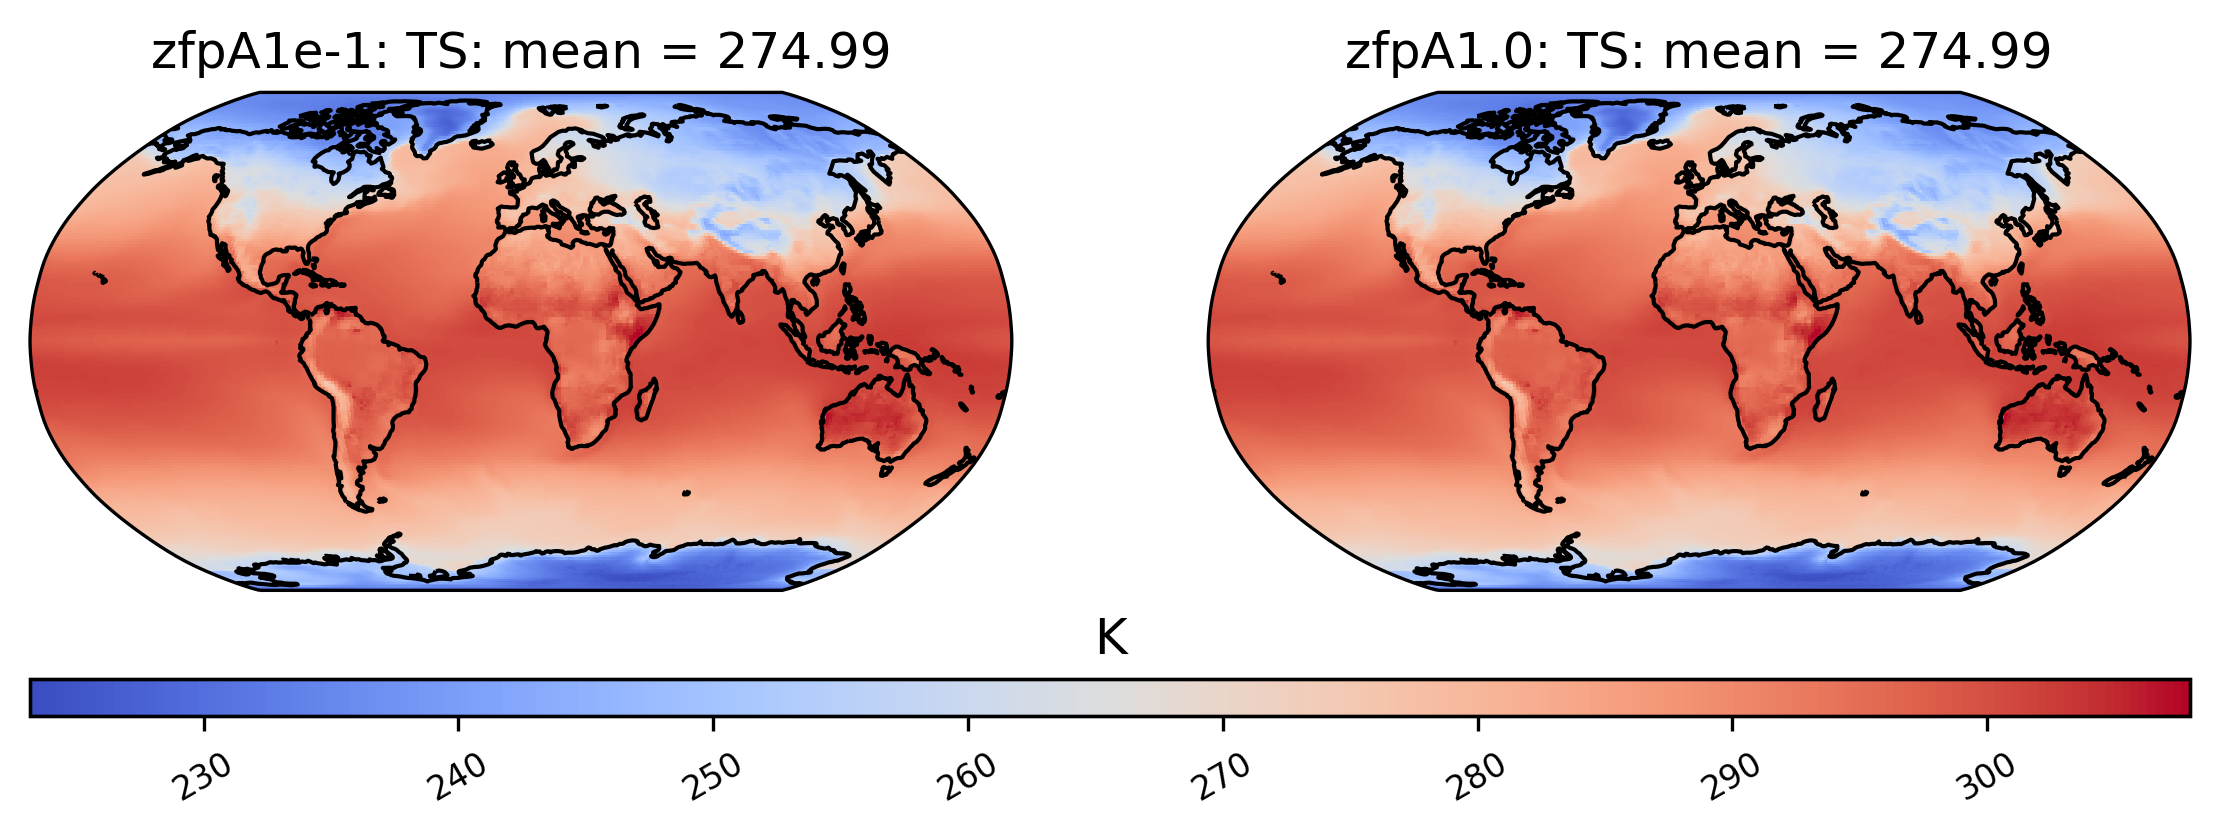

In [15]:
# comparison between mean TS values in col_ds for "zfpA1e-1" and "zfpA1.0 datasets"
ldcpy.plot(col_ds, "TS", set1='zfpA1e-1', metric='mean', set2='zfpA1.0', 
           plot_type="spatial_comparison", calc_ssim = True)

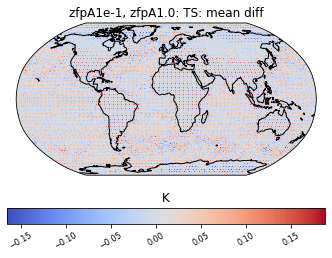

In [16]:
# diff between mean TS values in col_ds for "zfpA1e-1" and "zfpA1.0" datasets
ldcpy.plot(col_ds, "TS", set1='zfpA1e-1', metric='mean', set2='zfpA1.0', metric_type="diff", plot_type="spatial")

Sometimes comparison plots can look strikingly different, indicating a potential problem with the compression. This plot shows the probability of negative rainfall (PRECT). We would expect this metric to be zero everywhere on the globe (because negative rainfall does not make sense!), but the compressed output shows regions where the probability is significantly higher than zero:

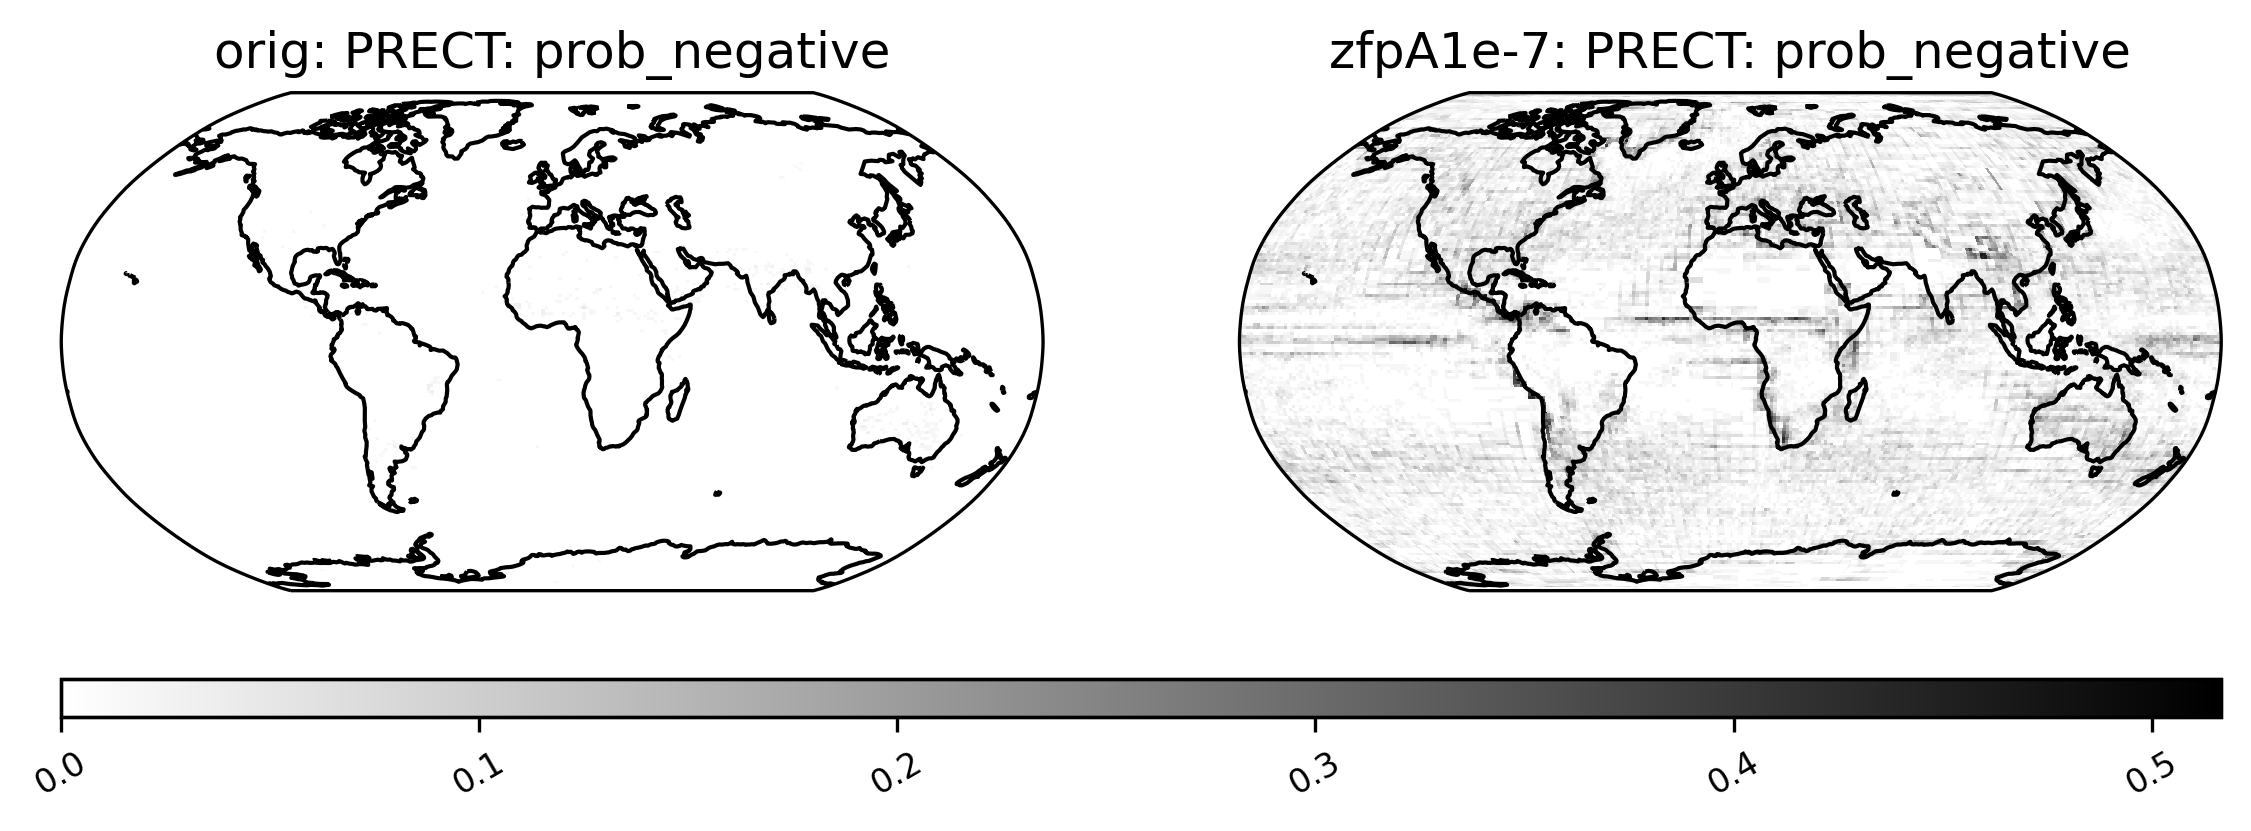

In [17]:
ldcpy.plot(col_ds2, "PRECT", set1='orig', metric='prob_negative', set2='zfpA1e-7', plot_type="spatial_comparison", 
           color="binary")

### Unusual Values (inf, -inf, NaN)

Some metrics result in values that are +/- infinity, or NaN (likely resulting from operations like 0/0 or inf/inf). NaN values are plotted in neon green, infinity is plotted in white, and negative infinity is plotted in black (regardless of color scheme). If infinite values are present in the plot data, arrows on either side of the colorbar are shown to indicate the color for +/- infinity. This plot shows the log of the ratio of the odds of positive rainfall over time in the compressed and original output, log(odds_positive compressed/odds_positive original). Here we are suppressing all of the divide by zero warnings for aesthetic reasons.

The following plot showcases some interesting plot features. We can see sections of the map that take NaN values, and other sections that are black because taking the log transform has resulted in many points with the value -inf:

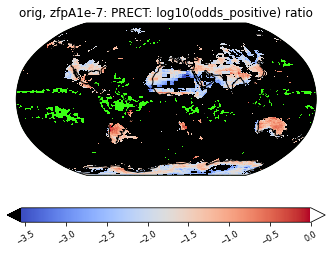

In [18]:
#suppress all of the divide by zero warnings
import warnings
warnings.filterwarnings('ignore')

# plot of the ratio of odds positive PRECT values in ds2 zfpA1e-7 dataset / ds2 orig dataset (log transform)
ldcpy.plot(col_ds2, 'PRECT', set1='orig', set2='zfpA1e-7', metric='odds_positive', metric_type="ratio", transform="log")

If all values are NaN, then the colorbar is not shown. Instead, a legend is shown indicating the green(!) color of NaN values, and the whole plot is colored gray. (If all values are infinite, then the plot is displayed normally with all values either black or white). Because the example dataset only contains 10 days of data, the deseasonalized lag-1 values and their variances are all 0, and so calculating the correlation of the lag-1 values will involve computing 0/0 = NaN:

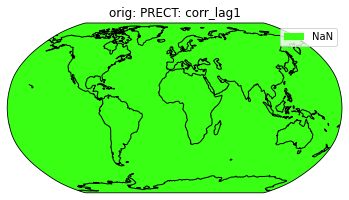

In [19]:
# plot of lag-1 correlation of PRECT values in col_ds2 orig dataset
ldcpy.plot(col_ds2, "PRECT", set1="orig", metric="corr_lag1")

### Other Spatial Plots

Sometimes, we may want to compute a metric on the difference between two datasets. For instance, the zscore metric calculates the zscore at each point under the null hypothesis that the true mean is zero, so using the "metric_of_diff" metric_type calculates the zscore of the diff between two datasets (to find the values that are significantly different between the two datasets). The zscore metric in particular gives additional information about the percentage of significant gridpoints in the plot title:

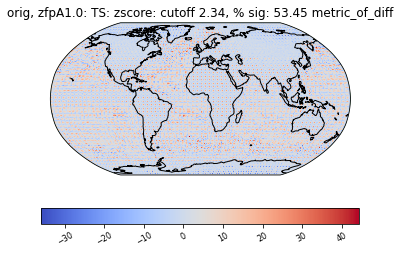

In [20]:
# plot of z-score under null hypothesis that "orig" value= "zfpA1.0" value
ldcpy.plot(col_ds, 'TS', set1='orig', metric='zscore', set2="zfpA1.0", metric_type="metric_of_diff")

## Time-Series Plots

We may want to aggregate the data spatially and look for trends over time.  Therefore, we can also create a time-series plot of the metrics by changing the plot_type to "time_series". For time-series plots, the metric values are on the y-axis and the x-axis represents time. We are also able to group the data by time, as shown below.







### Basic Time-Series Plot 

In the example below, we look at the 'orig' TS data in collection _col_ds_ , and display the spatial mean at each day of the year (our data consists of 100 days).



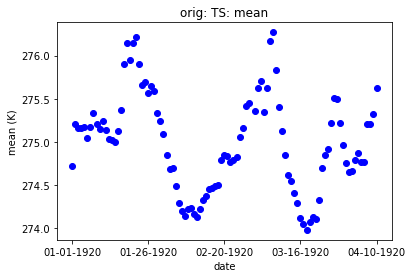

In [21]:
# Time-series plot of TS mean in ds orig dataset, grouped by day of year
ldcpy.plot(col_ds, "TS", set1='orig', metric='mean', plot_type="time_series")

### Using the group_by keyword

To group the data by time, use the "group_by" keyword. This plot shows the mean standard deviation over all latitude and longitude points for each month.  Note that this plot is not too interesting for our sample data, which has only 100 days of data.

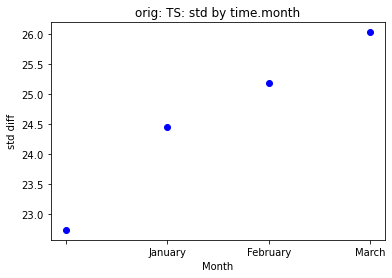

In [22]:
# Time-series plot of TS standard deviation in col_ds "orig" dataset, grouped by month
ldcpy.plot(col_ds, "TS", set1='orig', metric='std', plot_type="time_series", group_by="time.month")

One could also group by days of the year, as below. Again, because we have less than a year of data, this plot looks the same as the previous version.  However, this approach would be useful with data containing multiple years.

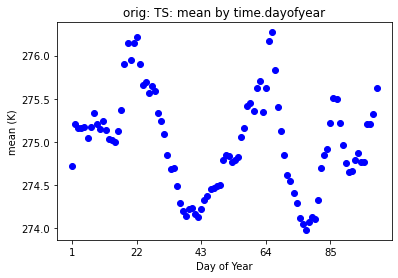

In [23]:
# Time-series plot of TS mean in col_ds "orig" dataset, grouped by day of year
ldcpy.plot(col_ds, "TS", set1='orig', metric='mean', plot_type="time_series", group_by="time.dayofyear")

### Histograms

We can also create a histogram of the data by changing the plot_type to histogram. Note that these histograms are currently generated from time-series metric values (a histogram of spatial values is not currently available).

The histogram below shows the mean values of TS in the 'orig' dataset in our collection _col_ds_.  Recall that this dataset contains 100 timeslices.

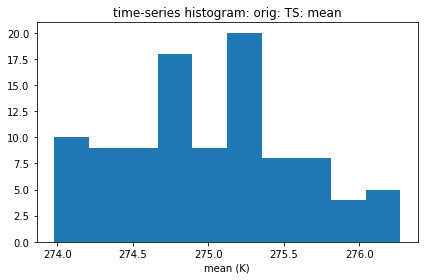

In [24]:
# Histogram of mean TS values in the ds 'orig' dataset

ldcpy.plot(col_ds, "TS", set1='orig', metric='mean', plot_type="histogram")

### Other Time-Series Plots

To do a comparison, a second dataset can be specified using the set2 keyword, just as in the spatial plots. The "metric" keyword can also be used in the same way. The example plot below shows the mean differences between the compressed and original standard deviation values for all 100 daily timeslices:

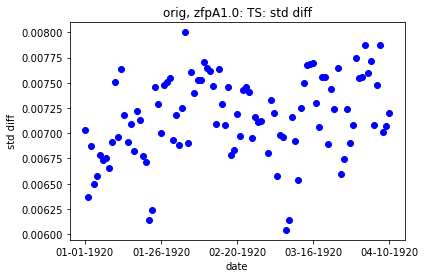

In [25]:
# Time-series plot of TS standard deviations diff between col_ds "orig" and "zfpA1.0" datasets grouped by day of year
ldcpy.plot(col_ds, "TS", set1='orig', metric='std', plot_type="time_series", set2="zfpA1.0", metric_type="diff")

### Subsetting

Subsetting is also possible on time-series data. The following plot makes use of the subset argument, which is used to plot metrics on only a portion of the data. A full list of available subsets is available [here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot). The following plot uses the 'first5' subset, which only shows the metric values for the first five time slices (in this case, days) of data:

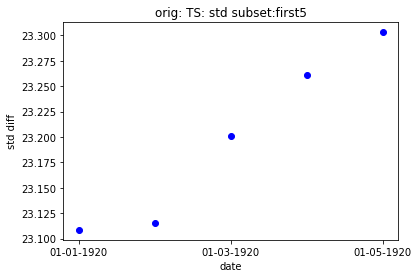

In [26]:
# Time-series plot of first five TS standard deviations in col_ds "orig" dataset
ldcpy.plot(col_ds, "TS", set1='orig', metric='std', plot_type="time_series", subset="first5")

Additionally, we can specify "lat" and "lon" keywords for time-series plots that give us a subset of the data at a single point, rather than averaging over all latitudes and longitudes. The nearest latitude and longitude point to the one specified is plotted (and the actual coordinates of the point can be found in the plot title). This plot, for example, shows the difference in mean rainfall between the compressed and original data at the location (44.76, -123.75):

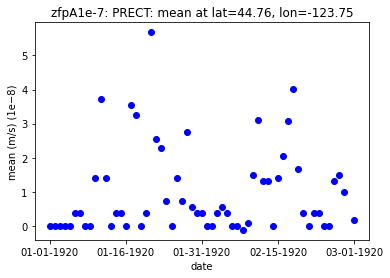

In [27]:
# Time series plot of PRECT mean data for col_ds2 "zfpA1e-7" dataset at the location (44.76, -123.75)

ldcpy.plot(col_ds2, "PRECT", set1='zfpA1e-7', metric="mean", plot_type="time_series", lat=44.76, lon=-123.75)

It is also possible to plot metrics for a subset of the data, by specifying the start and end indices of the data we are interested in. This command creates a time-series plot of the mean TS values for the first 45 days of data:

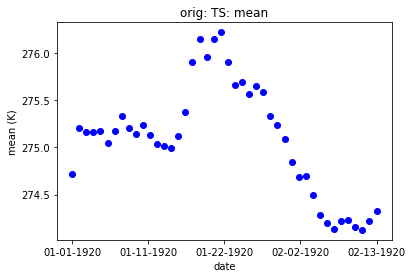

In [28]:
# Time series plot of first 45 TS mean data points for col_ds "orig" dataset

ldcpy.plot(col_ds, "TS", set1='orig', metric='mean', start=0, end=44, plot_type="time_series")